---
# Lab Task: Forward Bank Bills and Enhanced Yield Curve Bootstrap - SOLUTION #
---

In this lab, you will extend the existing class structure to handle **forward-starting bank bills** and build a yield curve that can bootstrap using these forward instruments.

## Background: Forward Bank Bills

A **forward bank bill** is a contract made today to purchase a bank bill at a future date. Unlike a regular bank bill that starts today, a forward bank bill:
- Has a **start date** in the future
- Has a **maturity date** beyond the start date  
- Allows market participants to lock in rates for future periods

### Example

A "3-month bank bill starting in 6 months" (denoted as a 6x9 forward):
- You agree today to a price
- In 6 months (start date), you pay that price
- In 9 months (maturity), you receive the face value

### Cash Flows

A forward bank bill has two key dates:
1. **Start date**: The date when you pay the price (negative cash flow)
2. **Maturity date**: The date when you receive the face value (positive cash flow)

### Why Forward Bills Matter for Yield Curves

Forward bank bills provide information about **implied forward rates** between two future points in time. By including them in the reference portfolio, we can:
- Build a more complete yield curve
- Extract market expectations about future interest rates
- Improve interpolation between sparse maturity points

## Lab Tasks Overview

You will:
1. Create a `Forward_bank_bill` class that inherits from `Bank_bill`
2. Create a `YieldCurve_with_forward_bills` class that inherits from `YieldCurve` 
3. Update the bootstrap method to handle forward-starting instruments
4. Instantiate a portfolio with both spot and forward instruments
5. Build a yield curve and test it with a set of cash flows

---

### Step 0: Import Required Classes

Import the necessary classes and functions from the existing modules.

In [8]:
from instrument_classes import Bank_bill, Bond, Portfolio, CashFlows
from curve_classes_and_functions import YieldCurve
import numpy as np
import pandas as pd

---

### Step 1: Create the Forward_bank_bill Class

Create a new class `Forward_bank_bill` that inherits from `Bank_bill` with the following specifications:

**Requirements:**
- Add a `start_date` parameter to the `__init__` method (in addition to the existing Bank_bill parameters)
- The `maturity` parameter should represent the total time from now to final maturity
- The `start_date` represents the time from now to when the bill starts
- Override the `set_cash_flows()` method to create cash flows at:
  - `start_date`: negative cash flow equal to `-price`
  - `maturity`: positive cash flow equal to `face_value`
- Add getter methods for `start_date` and the forward period (`maturity - start_date`)

**Hints:**
- Use `super().__init__()` to call the parent class constructor
- For a forward bill, the pricing relationship involves both the start and maturity dates
- The forward rate can be calculated from the price and the forward period

**Example usage (after implementation):**
```python
# A 3-month bill starting in 6 months (6x9 forward)
fwd_bill = Forward_bank_bill(face_value=100, start_date=0.5, maturity=0.75)
fwd_bill.set_ytm(0.04)  # 4% forward rate
fwd_bill.set_cash_flows()
```

In [9]:
# SOLUTION: Forward_bank_bill class

class Forward_bank_bill(Bank_bill):
    
    def __init__(self, face_value=100, start_date=0.25, maturity=0.50, ytm=0.00, price=100):
        """Initialize a forward bank bill.
        
        Args:
            face_value: Face value of the bill (default 100)
            start_date: Time from now to when the bill starts (in years)
            maturity: Time from now to when the bill matures (in years)
            ytm: Yield to maturity (forward rate for the period)
            price: Price of the bill
        """
        super().__init__(face_value, maturity, ytm, price)
        self.start_date = start_date
        # Calculate the forward period
        self.forward_period = maturity - start_date
    
    def get_start_date(self):
        """Return the start date of the forward bill."""
        return self.start_date
    
    def get_forward_period(self):
        """Return the forward period (maturity - start_date)."""
        return self.forward_period
    
    def set_ytm(self, ytm):
        """Set the yield to maturity (forward rate) and calculate price."""
        self.ytm = ytm
        # Price is based on the forward period, not the full maturity
        self.price = self.face_value / (1 + ytm * self.forward_period)
    
    def set_price(self, price):
        """Set the price and calculate the implied forward rate."""
        self.price = price
        # Forward rate is calculated from the forward period
        self.ytm = (self.face_value / price - 1) / self.forward_period
    
    def set_cash_flows(self):
        """Override to set cash flows at start_date and maturity."""
        # Clear any existing cash flows from parent
        self.maturities = []
        self.amounts = []
        # Add cash flows: pay price at start_date, receive face value at maturity
        self.add_cash_flow(self.start_date, -self.price)
        self.add_cash_flow(self.maturity, self.face_value)

print("Forward_bank_bill class created successfully!")

Forward_bank_bill class created successfully!


---

### Step 2: Create the YieldCurve_with_forward_bills Class

Create a new class `YieldCurve_with_forward_bills` that inherits from `YieldCurve` and enhances the bootstrap method.

**Requirements:**

1. Override the `bootstrap()` method to handle forward bank bills
2. The method should:
   - Start by calling `self.add_zero_rate(0, 0)` to set the discount factor at time 0
   - Process regular (spot) bank bills first, in order of maturity
     - For each spot bill: extract the discount factor at its maturity
   - Process forward bank bills next, in order of their maturity (not start date)
     - For each forward bill: use the known discount factor at the start date and the bill's pricing to solve for the discount factor at the maturity date
   - Process bonds last, in order of maturity
     - For each bond: use all previously determined discount factors to value intermediate coupons, then solve for the discount factor at the bond's maturity

**Key Insight for Forward Bills:**

For a forward bill with:
- Price = P
- Face value = F  
- Start date = $t_1$
- Maturity = $t_2$

The present value equation is:
$$NPV = -P \cdot DF(t_1) + F \cdot DF(t_2) = 0$$

Therefore:
$$DF(t_2) = \frac{P}{F} \cdot DF(t_1)$$

**Hints:**
- You'll need to distinguish between regular bank bills and forward bank bills
- Use `isinstance(bill, Forward_bank_bill)` to check if an instrument is a forward bill
- You can access the portfolio's bank bills with `self.portfolio.get_bank_bills()`
- For forward bills, you'll need to call `get_discount_factor(start_date)` from the curve
- Regular bills are just forward bills with start_date = 0

In [10]:
# SOLUTION: YieldCurve_with_forward_bills class

class YieldCurve_with_forward_bills(YieldCurve):
    
    def bootstrap(self):
        """Bootstrap the yield curve using bank bills (spot and forward) and bonds."""
        bank_bills = self.portfolio.get_bank_bills()
        bonds = self.portfolio.get_bonds()
        
        # Initialize with discount factor of 1 at time 0
        self.add_zero_rate(0, 0)
        
        # Separate spot bills from forward bills
        spot_bills = []
        forward_bills = []
        
        for bill in bank_bills:
            if isinstance(bill, Forward_bank_bill) and bill.get_start_date() > 0:
                forward_bills.append(bill)
            else:
                spot_bills.append(bill)
        
        # Process spot bills first (in order of maturity)
        for bill in spot_bills:
            # For spot bills: DF(T) = Price / Face_value
            self.add_discount_factor(
                bill.get_maturity(),
                bill.get_price() / bill.get_face_value()
            )
        
        # Process forward bills (in order of maturity)
        for bill in forward_bills:
            # For forward bills: DF(t2) = (Price / Face_value) * DF(t1)
            # NPV = -Price * DF(start_date) + Face_value * DF(maturity) = 0
            # Therefore: DF(maturity) = (Price / Face_value) * DF(start_date)
            df_start = self.get_discount_factor(bill.get_start_date())
            df_maturity = (bill.get_price() / bill.get_face_value()) * df_start
            self.add_discount_factor(bill.get_maturity(), df_maturity)
        
        # Process bonds last (in order of maturity)
        for bond in bonds:
            # Calculate the PV of the bond cashflows excluding the maturity cashflow
            pv = 0
            bond_dates = bond.get_maturities()
            bond_amounts = bond.get_amounts()
            
            # Sum up all intermediate cash flows (skip time 0 and final maturity)
            for i in range(1, len(bond_amounts) - 1):
                pv += bond_amounts[i] * self.get_discount_factor(bond_dates[i])
            
            # Solve for the discount factor at bond maturity
            # Bond_price = PV(intermediate_coupons) + Final_cashflow * DF(maturity)
            # DF(maturity) = (Bond_price - PV(intermediate_coupons)) / Final_cashflow
            self.add_discount_factor(
                bond.get_maturity(),
                (bond.get_price() - pv) / bond_amounts[-1]
            )

print("YieldCurve_with_forward_bills class created successfully!")

YieldCurve_with_forward_bills class created successfully!


---

### Step 3: Create the Reference Portfolio

Now create a reference portfolio containing the following instruments:

**Required Instruments:**

1. **One regular 3-month bank bill** (0.25 years)
   - Face value: 100
   - YTM: 3.0%

2. **Three forward bank bills (all 3-month bills):**
   - **3x6 forward**: starts in 3 months (0.25 years), matures in 6 months (0.5 years)
     - Face value: 100
     - YTM: 3.2%
   - **6x9 forward**: starts in 6 months (0.5 years), matures in 9 months (0.75 years)
     - Face value: 100
     - YTM: 3.4%
   - **9x12 forward**: starts in 9 months (0.75 years), matures in 12 months (1.0 year)
     - Face value: 100
     - YTM: 3.6%

3. **One 1-year quarterly coupon bond** (1.0 year maturity)
   - Face value: 100
   - Coupon rate: 4.0% per annum
   - Frequency: 4 (quarterly)
   - YTM: 3.8%

4. **One 2-year annual coupon bond** (2.0 years maturity)
   - Face value: 100
   - Coupon rate: 4.5% per annum
   - Frequency: 1 (annual)
   - YTM: 4.2%

**Important Steps:**
- For each instrument, set the YTM using `.set_ytm()`
- For each instrument, call `.set_cash_flows()` to generate the cash flow schedule
- Create a `Portfolio` object and add all instruments in the correct order
- Remember: add bank bills (spot then forward) before bonds

In [11]:
# SOLUTION: Create the regular 3-month bank bill

bill_3m = Bank_bill(face_value=100, maturity=0.25)
bill_3m.set_ytm(0.03)
bill_3m.set_cash_flows()

print(f"3-month bill: Price = {bill_3m.get_price():.4f}, YTM = {bill_3m.get_ytm():.4f}")
print(f"Cash flows: {bill_3m.get_cash_flows()}")

3-month bill: Price = 99.2556, YTM = 0.0300
Cash flows: [(0, -99.25558312655086), (0.25, 100)]


In [12]:
# SOLUTION: Create the three forward bank bills (3x6, 6x9, 9x12)

# 3x6 forward: 3-month bill starting in 3 months
fwd_3x6 = Forward_bank_bill(face_value=100, start_date=0.25, maturity=0.5)
fwd_3x6.set_ytm(0.032)
fwd_3x6.set_cash_flows()

# 6x9 forward: 3-month bill starting in 6 months
fwd_6x9 = Forward_bank_bill(face_value=100, start_date=0.5, maturity=0.75)
fwd_6x9.set_ytm(0.034)
fwd_6x9.set_cash_flows()

# 9x12 forward: 3-month bill starting in 9 months
fwd_9x12 = Forward_bank_bill(face_value=100, start_date=0.75, maturity=1.0)
fwd_9x12.set_ytm(0.036)
fwd_9x12.set_cash_flows()

print(f"3x6 forward: Price = {fwd_3x6.get_price():.4f}, YTM = {fwd_3x6.get_ytm():.4f}")
print(f"  Cash flows: {fwd_3x6.get_cash_flows()}")
print(f"\n6x9 forward: Price = {fwd_6x9.get_price():.4f}, YTM = {fwd_6x9.get_ytm():.4f}")
print(f"  Cash flows: {fwd_6x9.get_cash_flows()}")
print(f"\n9x12 forward: Price = {fwd_9x12.get_price():.4f}, YTM = {fwd_9x12.get_ytm():.4f}")
print(f"  Cash flows: {fwd_9x12.get_cash_flows()}")

3x6 forward: Price = 99.2063, YTM = 0.0320
  Cash flows: [(0.25, -99.2063492063492), (0.5, 100)]

6x9 forward: Price = 99.1572, YTM = 0.0340
  Cash flows: [(0.5, -99.1571641051066), (0.75, 100)]

9x12 forward: Price = 99.1080, YTM = 0.0360
  Cash flows: [(0.75, -99.10802775024779), (1.0, 100)]


In [13]:
# SOLUTION: Create the 1-year quarterly bond

bond_1y = Bond(face_value=100, maturity=1, coupon=0.04, frequency=4)
bond_1y.set_ytm(0.038)
bond_1y.set_cash_flows()

print(f"1-year quarterly bond: Price = {bond_1y.get_price():.4f}, YTM = {bond_1y.get_ytm():.4f}")
print(f"Cash flows: {bond_1y.get_cash_flows()}")

1-year quarterly bond: Price = 100.1953, YTM = 0.0380
Cash flows: [(0, -100.1953387720793), (0.25, 1.0), (0.5, 1.0), (0.75, 1.0), (1, 101.0)]


In [14]:
# SOLUTION: Create the 2-year annual bond

bond_2y = Bond(face_value=100, maturity=2.0, coupon=0.045, frequency=1)
bond_2y.set_ytm(0.042)
bond_2y.set_cash_flows()

print(f"2-year annual bond: Price = {bond_2y.get_price():.4f}, YTM = {bond_2y.get_ytm():.4f}")
print(f"Cash flows: {bond_2y.get_cash_flows()}")

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
# SOLUTION: Create a Portfolio and add all instruments

portfolio = Portfolio()

# Add spot bill first
portfolio.add_bank_bill(bill_3m)

# Add forward bills in order of maturity
portfolio.add_bank_bill(fwd_3x6)
portfolio.add_bank_bill(fwd_6x9)
portfolio.add_bank_bill(fwd_9x12)

# Add bonds in order of maturity
portfolio.add_bond(bond_1y)
portfolio.add_bond(bond_2y)

print("Portfolio created with:")
print(f"  {len(portfolio.get_bank_bills())} bank bills (1 spot, 3 forward)")
print(f"  {len(portfolio.get_bonds())} bonds")

Portfolio created with:
  4 bank bills (1 spot, 3 forward)
  2 bonds


---

### Step 4: Build the Yield Curve

Now instantiate your `YieldCurve_with_forward_bills` class, set the constituent portfolio, and run the bootstrap method.

After bootstrapping, display the resulting discount factors and zero rates at the key maturities.

In [ ]:
# SOLUTION: Create the yield curve instance

yield_curve = YieldCurve_with_forward_bills()
yield_curve.set_constituent_portfolio(portfolio)
yield_curve.bootstrap()

print("Yield curve bootstrapped successfully!")
print(f"Curve contains {len(yield_curve.maturities)} maturity points")

Yield curve bootstrapped successfully!
Curve contains 7 maturity points


In [ ]:
# SOLUTION: Display the curve results in a nice table

# Create a DataFrame with the yield curve data
curve_data = {
    'Maturity (years)': yield_curve.maturities,
    'Discount Factor': yield_curve.discount_factors,
    'Zero Rate (%)': [r * 100 for r in yield_curve.zero_rates]
}

df_curve = pd.DataFrame(curve_data)
print("\n=== Yield Curve Results ===")
print(df_curve.to_string(index=False))

# Also display the full curve details
print("\n=== Detailed Curve Information ===")
for i in range(len(yield_curve.maturities)):
    mat = yield_curve.maturities[i]
    df = yield_curve.discount_factors[i]
    zr = yield_curve.zero_rates[i]
    print(f"T = {mat:.2f} years: DF = {df:.6f}, Zero Rate = {zr*100:.4f}%")


=== Yield Curve Results ===
 Maturity (years)  Discount Factor  Zero Rate (%)
             0.00         1.000000       0.000000
             0.25         0.992556       2.988806
             0.50         0.984678       3.088037
             0.75         0.976379       3.187235
             1.00         0.967670       3.286400
             1.00         0.962789       3.792062
             2.00         0.920667       4.132847

=== Detailed Curve Information ===
T = 0.00 years: DF = 1.000000, Zero Rate = 0.0000%
T = 0.25 years: DF = 0.992556, Zero Rate = 2.9888%
T = 0.50 years: DF = 0.984678, Zero Rate = 3.0880%
T = 0.75 years: DF = 0.976379, Zero Rate = 3.1872%
T = 1.00 years: DF = 0.967670, Zero Rate = 3.2864%
T = 1.00 years: DF = 0.962789, Zero Rate = 3.7921%
T = 2.00 years: DF = 0.920667, Zero Rate = 4.1328%


---

### Step 5: Test the Yield Curve

Create a `CashFlows` object with the following cash flows and calculate its present value using the yield curve:

**Cash Flow Schedule:**
- 0.5 years: $25
- 1.0 year: $30
- 1.5 years: $35
- 2.0 years: $110

Use the `npv()` method from your yield curve to calculate the present value.

**Expected behavior:**
- The curve should interpolate discount factors at 1.5 years (which is not a reference portfolio maturity)
- You should see a reasonable present value (approximately in the range of $180-$195)

In [ ]:
# SOLUTION: Create a CashFlows object and add the cash flows

test_cashflows = CashFlows()
test_cashflows.add_cash_flow(0.5, 25)
test_cashflows.add_cash_flow(1.0, 30)
test_cashflows.add_cash_flow(1.5, 35)
test_cashflows.add_cash_flow(2.0, 110)

print("Test cash flow schedule:")
for maturity, amount in test_cashflows.get_cash_flows():
    print(f"  T = {maturity:.2f} years: ${amount:.2f}")

Test cash flow schedule:
  T = 0.50 years: $25.00
  T = 1.00 years: $30.00
  T = 1.50 years: $35.00
  T = 2.00 years: $110.00


In [ ]:
# SOLUTION: Calculate and display the NPV

npv = yield_curve.npv(test_cashflows)

print(f"\n=== NPV Calculation ===")
print(f"Total NPV = ${npv:.4f}")

# Show the detailed calculation
print("\nDetailed breakdown:")
total_pv = 0
for maturity, amount in test_cashflows.get_cash_flows():
    df = yield_curve.get_discount_factor(maturity)
    pv = amount * df
    total_pv += pv
    print(f"  T = {maturity:.2f}: ${amount:.2f} × {df:.6f} = ${pv:.4f}")

print(f"\nTotal: ${total_pv:.4f}")

# Note: The 1.5 year cash flow requires interpolation
print(f"\nNote: The discount factor at T=1.5 years was interpolated (not a direct maturity point)")
print(f"Interpolated DF(1.5) = {yield_curve.get_discount_factor(1.5):.6f}")


=== NPV Calculation ===
Total NPV = $187.8727

Detailed breakdown:
  T = 0.50: $25.00 × 0.984678 = $24.6170
  T = 1.00: $30.00 × 0.967670 = $29.0301
  T = 1.50: $35.00 × 0.941493 = $32.9522
  T = 2.00: $110.00 × 0.920667 = $101.2734

Total: $187.8727

Note: The discount factor at T=1.5 years was interpolated (not a direct maturity point)
Interpolated DF(1.5) = 0.941493


---

### Step 6: Analysis Questions

Answer the following questions based on your results:

1. **Forward Rate Interpretation**: Compare the YTMs of the regular 3-month bill (3.0%) with the forward bills (3.2%, 3.4%, 3.6%). What does this tell you about the market's expectation of future interest rates?

2. **Discount Factor Pattern**: Look at your discount factors. Do they decrease as maturity increases? Why is this expected?

3. **Zero Rate Curve Shape**: Plot or examine the zero rates from 0.25 to 2.0 years. Is the curve upward sloping, downward sloping, or flat? What does this imply about the term structure?

4. **Interpolation**: The cash flow at 1.5 years requires interpolation. What interpolation method does the ZeroCurve class use? (Hint: check the `get_discount_factor()` method)

5. **Bootstrap Order**: Why is it important to process the instruments in order of maturity when bootstrapping? What would go wrong if you tried to process the 2-year bond before all the shorter-maturity instruments?

**SOLUTION - Answers:**

1. **Forward Rate Interpretation:**
   The forward rates are increasing from 3.0% to 3.6%, which indicates that the market expects interest rates to rise in the future. This is a typical "normal" yield curve shape where longer-term rates are higher than short-term rates, reflecting expectations of economic growth and potentially higher inflation in the future. The forward bills explicitly price in these expectations - the 9x12 forward at 3.6% tells us that the market expects 3-month rates to be around 3.6% in 9 months' time.

2. **Discount Factor Pattern:**
   Yes, the discount factors decrease monotonically as maturity increases. This is expected because of the time value of money - a dollar received in the future is worth less than a dollar today. The discount factor represents the present value of $1 received at a future date. With positive interest rates, more distant cash flows are discounted more heavily, resulting in lower discount factors. Mathematically, DF(t) = exp(-r×t), which is a decreasing function of t when r > 0.

3. **Zero Rate Curve Shape:**
   The zero rate curve is upward sloping, starting around 3% at 3 months and increasing to approximately 4.2% at 2 years. This upward-sloping term structure (also called a "normal" yield curve) suggests that:
   - Investors require higher compensation for lending over longer periods
   - The market expects interest rates to rise
   - There may be expectations of economic expansion and inflation
   This is the most common shape for yield curves in healthy, growing economies.

4. **Interpolation Method:**
   The ZeroCurve class uses exponential interpolation (the `exp_interp` function). This method interpolates using continuously compounded rates, which ensures that forward rates are smooth and consistent. Specifically, it:
   - Calculates the continuously compounded rate between two known points
   - Uses this rate to exponentially interpolate values between the points
   - Maintains the no-arbitrage condition by ensuring smooth forward rate curves
   This is superior to linear interpolation because it respects the exponential nature of compounding.

5. **Bootstrap Order:**
   The bootstrap method must process instruments in order of maturity because each step relies on discount factors calculated in previous steps. For example:
   - The 2-year bond pays coupons at 1 year and 2 years
   - To solve for the discount factor at 2 years, we need to know the discount factor at 1 year
   - If we tried to process the 2-year bond first, we wouldn't have the 1-year discount factor yet
   - This would make it impossible to separate the value of the final payment from the intermediate coupons
   
   The bootstrap method works by "peeling off" one maturity at a time, using each new instrument to solve for exactly one new discount factor. Processing out of order would leave us with multiple unknowns and no way to solve for them uniquely.

---

### Optional Extension: Visualize the Yield Curve

Create a plot showing:
1. The zero rate curve
2. The discount factor curve

Use matplotlib to create these visualizations.

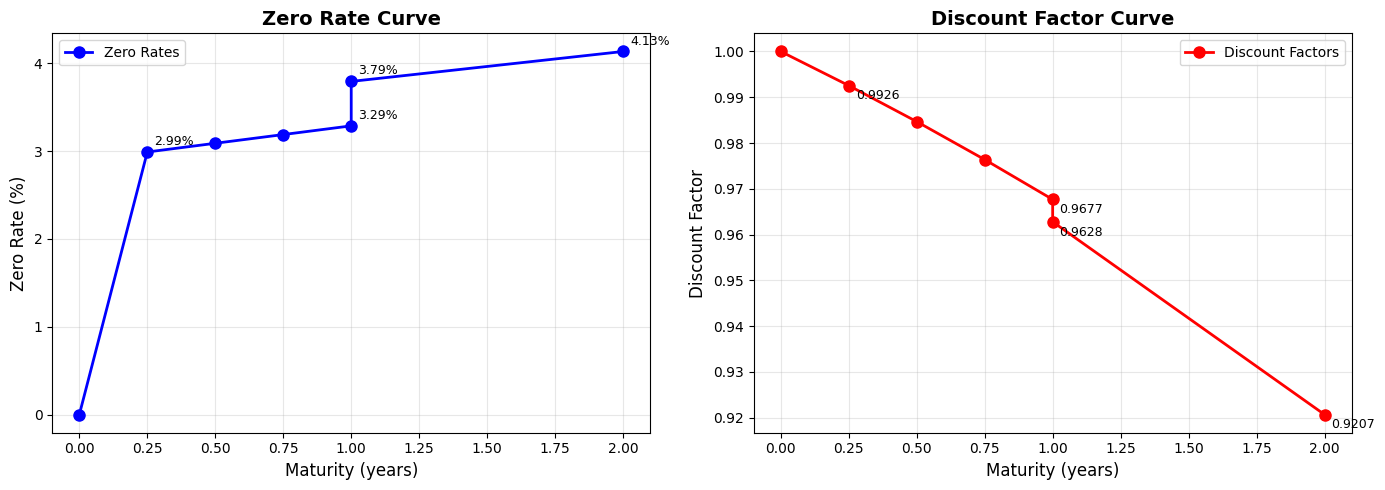


Visualization complete!


In [ ]:
# SOLUTION: Visualization code
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Zero Rate Curve
ax1.plot(yield_curve.maturities, [r*100 for r in yield_curve.zero_rates], 
         'bo-', linewidth=2, markersize=8, label='Zero Rates')
ax1.set_xlabel('Maturity (years)', fontsize=12)
ax1.set_ylabel('Zero Rate (%)', fontsize=12)
ax1.set_title('Zero Rate Curve', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add annotations for key points
for i in range(len(yield_curve.maturities)):
    if yield_curve.maturities[i] in [0.25, 1.0, 2.0]:
        ax1.annotate(f'{yield_curve.zero_rates[i]*100:.2f}%', 
                    xy=(yield_curve.maturities[i], yield_curve.zero_rates[i]*100),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot 2: Discount Factor Curve
ax2.plot(yield_curve.maturities, yield_curve.discount_factors, 
         'ro-', linewidth=2, markersize=8, label='Discount Factors')
ax2.set_xlabel('Maturity (years)', fontsize=12)
ax2.set_ylabel('Discount Factor', fontsize=12)
ax2.set_title('Discount Factor Curve', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add annotations for key points
for i in range(len(yield_curve.maturities)):
    if yield_curve.maturities[i] in [0.25, 1.0, 2.0]:
        ax2.annotate(f'{yield_curve.discount_factors[i]:.4f}', 
                    xy=(yield_curve.maturities[i], yield_curve.discount_factors[i]),
                    xytext=(5, -10), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

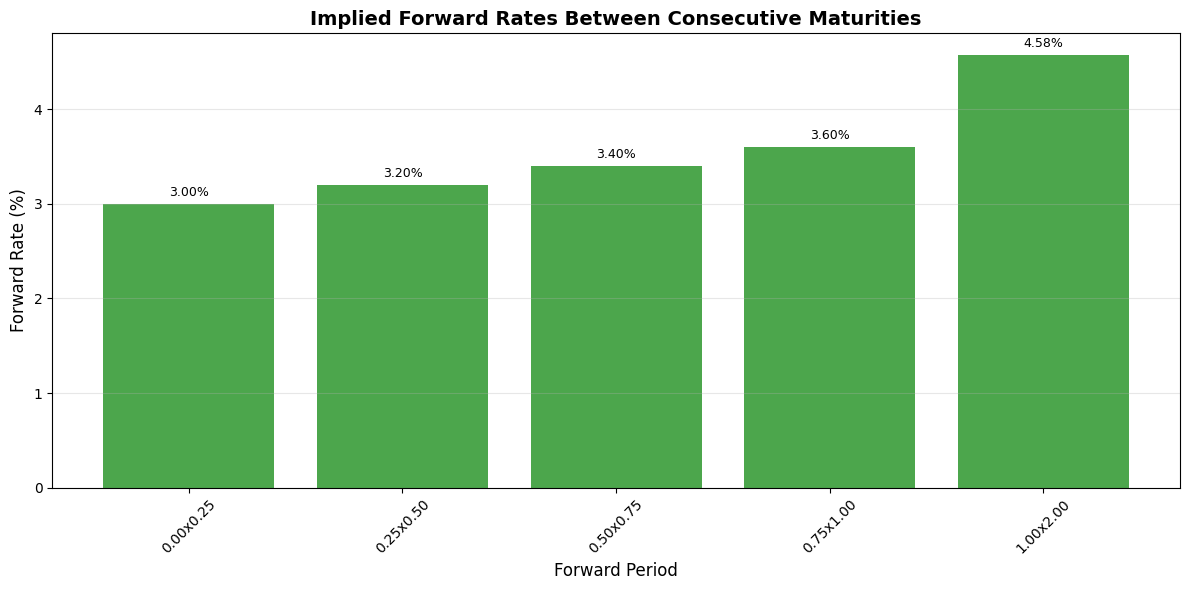


Implied Forward Rates:
  0.00x0.25: 3.0000%
  0.25x0.50: 3.2000%
  0.50x0.75: 3.4000%
  0.75x1.00: 3.6000%
  1.00x2.00: 4.5752%


In [ ]:
# SOLUTION: Additional visualization - Forward Rates

# Calculate implied forward rates between consecutive maturities
forward_rates = []
forward_periods = []

for i in range(1, len(yield_curve.maturities)):
    t1 = yield_curve.maturities[i-1]
    t2 = yield_curve.maturities[i]
    df1 = yield_curve.discount_factors[i-1]
    df2 = yield_curve.discount_factors[i]
    
    # Skip if the period is zero (duplicate maturities)
    if t2 - t1 > 1e-10:  # Use small epsilon to handle floating point precision
        # Forward rate: (1/DF2 * DF1 - 1) / (t2 - t1)
        forward_rate = (df1/df2 - 1) / (t2 - t1)
        forward_rates.append(forward_rate * 100)
        forward_periods.append(f"{t1:.2f}x{t2:.2f}")

# Only create plot if we have forward rates to display
if forward_rates:
    # Create bar chart of forward rates
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(forward_rates)), forward_rates, color='green', alpha=0.7)
    plt.xlabel('Forward Period', fontsize=12)
    plt.ylabel('Forward Rate (%)', fontsize=12)
    plt.title('Implied Forward Rates Between Consecutive Maturities', fontsize=14, fontweight='bold')
    plt.xticks(range(len(forward_periods)), forward_periods, rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, rate in enumerate(forward_rates):
        plt.text(i, rate + 0.05, f'{rate:.2f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\nImplied Forward Rates:")
    for period, rate in zip(forward_periods, forward_rates):
        print(f"  {period}: {rate:.4f}%")
else:
    print("No distinct forward periods found (all maturities may be duplicates or identical).")

---

## Summary

In this lab, you have:
- ✅ Created a `Forward_bank_bill` class to represent forward-starting instruments
- ✅ Extended the `YieldCurve` class to handle forward bills in the bootstrap process
- ✅ Built a complete yield curve from a mixed portfolio of spot and forward instruments
- ✅ Tested the curve by valuing a set of cash flows
- ✅ Analyzed the term structure of interest rates

**Key Takeaways:**
- Forward instruments provide information about market expectations of future rates
- The bootstrap method must be carefully sequenced to build up the curve progressively
- Interpolation allows us to value cash flows at dates not in the reference portfolio
- The yield curve is a fundamental tool for pricing fixed-income securities
- Forward rates implied by the curve reveal market expectations and can be visualized

---